In [0]:
# Remember to turn on GPU!!!
# installing packages
!pip install keras --upgrade
!pip install tensorflow --upgrade
!pip install kaggle-cli

# install cv2
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

### Download our data straight from Kaggle and unzip
#!kg download -u "xxx" -p "xxx" -c data-science-bowl-2018 
#!unzip -q stage1_train.zip -d stage1_train

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages
Requirement already up-to-date: six>=1.9.0 in /usr/local/lib/python3.6/dist-packages (from keras)
Requirement already up-to-date: pyyaml in /usr/local/lib/python3.6/dist-packages (from keras)
Requirement already up-to-date: scipy>=0.14 in /usr/local/lib/python3.6/dist-packages (from keras)
Requirement already up-to-date: numpy>=1.9.1 in /usr/local/lib/python3.6/dist-packages (from keras)
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages
Requirement already up-to-date: astor>=0.6.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
Requirement already up-to-date: protobuf>=3.4.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
Requirement already up-to-date: tensorboard<1.7.0,>=1.6.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
Requirement already up-to-date: grpcio>=1.8.6 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
Require

In [0]:
# https://stackoverflow.com/questions/48875783/how-to-upload-many-files-to-google-colab

#### FIRST WE SHALL FUSE THE DRIVE
#### CUZ THATS WHAT YOU DO ON 

# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse



# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()


# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


# Create a directory and mount Google Drive using that directory.
!mkdir -p Drive
!google-drive-ocamlfuse My Drive

# Navigate to our project directory
import os
#os.chdir('/content/Drive/Data Science Bowl 2018')


Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
os.chdir('/content/')
!ls

datalab  stage1_sample_submission.csv.zip  stage1_train_labels.csv.zip
Drive	 stage1_test.zip		   stage1_train.zip
My	 stage1_train


# Libraries and Global Parameters 

In [2]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.util import img_as_bool, img_as_uint, img_as_ubyte, img_as_int
from skimage.transform import resize
from skimage.morphology import label
import random
from random import randint 
from keras import regularizers
from keras.models import Model, load_model
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, Dense, \
    UpSampling2D, BatchNormalization, add, Dropout, Flatten, Conv2DTranspose
from keras.layers.core import Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras import backend as K
from keras.losses import binary_crossentropy, sparse_categorical_crossentropy


####### UPDATE THIS #########
#############################

model_num = 4

#############################
#############################

model_checkpoint_file= 'unet_v' + str(model_num) +'.h5'
submission_filename = 'unet_v' + str(model_num) +'_pred.csv'

# Root folders for test and training data
train_root = "./stage1_train"
test_root = "./stage1_test"

# Size we resize all images to
#image_size = (128,128)

img_height = 128
img_width = 128
img_channels = 1 # 1 for B&W, 3 for RGB

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
#warnings.resetwarnings()

/home/cambonator/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Preparing the Data

In [3]:
# Import images (either test or training)
# Decolorize, resize, store in array, and save filenames, etc.
def import_images(root):
    dirs = os.listdir(root)
    filenames=[os.path.join(root,file_id) + "/images/"+file_id+".png" for file_id in dirs]
    images=[imread(imagefile,as_grey=True) for imagefile in filenames]
    resized_images = [ resize(image,(img_width,img_height)) for image in images] 
    Array = np.reshape(np.array(resized_images),
                       (len(resized_images),img_height,img_width,img_channels))
    #Array = np.reshape(np.array(img_as_ubyte(resized_images),dtype=np.uint8).astype(np.uint8),
    #                   (len(resized_images),img_height,img_width,img_channels))
    
    print(Array.mean())
    print(Array.std())

    # Normalize inputs
    Array = ((Array - Array.mean())/Array.std())

    print(Array.mean())
    print(Array.std())
    print(images[0].dtype)
   # print(resized_images[0].dtype)
    print(Array[0,0,0,0].dtype)
    return Array, images, filenames, dirs

train_X, train_images, train_filenames, train_dirs = import_images(train_root)

0.1609027966569336
0.2496216507688851
8.368098916950806e-17
0.9999999999999997
float64
float64


In [4]:
## Import Training Masks
# this takes longer than the training images because we have to
# combine a lot of mask files

# This function creates a single combined mask image 
# when given a list of masks
# Probably a computationally faster way to do this...
def collapse_masks(mask_list):
    for i, mask_file in enumerate(mask_list):        
        if i != 0:
            # combine mask with previous mask in list 
            mask = np.maximum(mask, imread(os.path.join(train_root,mask_file)))
        else:
            # read first mask in
            mask = imread(os.path.join(train_root,mask_file))
    
    return mask

# Import all the masks
train_mask_dirs = [ os.path.join(path, 'masks') for path in os.listdir(train_root) ]
train_mask_files = [ [os.path.join(dir,file) for file in os.listdir(os.path.join(train_root,dir)) ]  for dir in train_mask_dirs]
train_masks = [ collapse_masks(mask_files) for mask_files in train_mask_files ]
resized_train_masks = [ img_as_bool(resize(image,(img_width,img_height))) for image in train_masks] 
train_Y = np.reshape(np.array(resized_train_masks),(len(resized_train_masks),img_height,img_width,img_channels))

Image #: 151


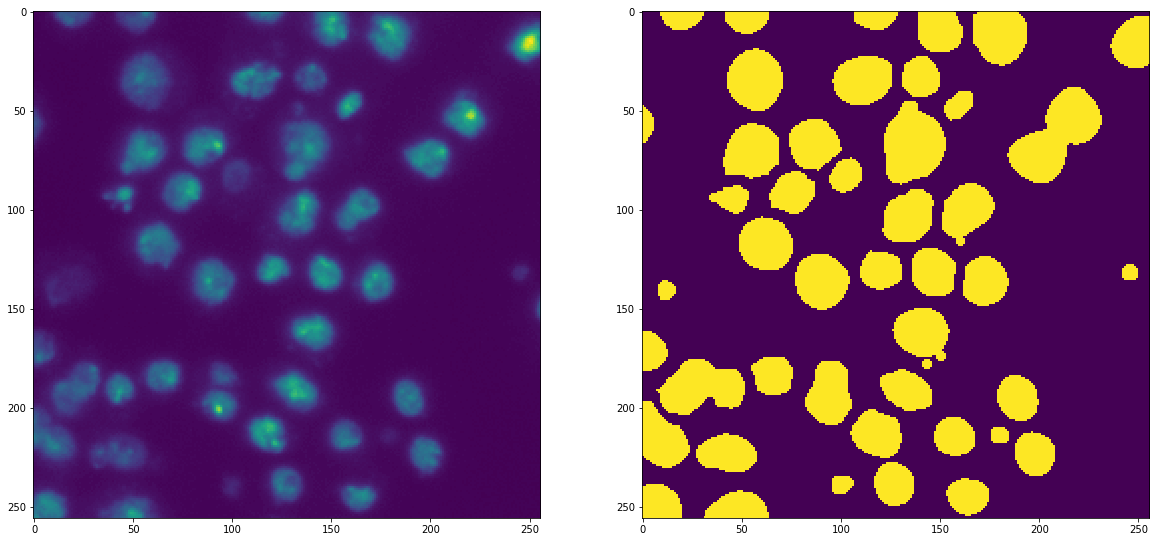

In [5]:
# Plot images side by side for a list of datasets
def plot_side_by_side(ds_list,image_num,size=(15,10)):
    print('Image #: ' + str(image_num))
    fig = plt.figure(figsize=size)

    for i in range(len(ds_list)):
        ax1 = fig.add_subplot(1,len(ds_list),i+1)
        ax1.imshow(ds_list[i][image_num])

    plt.show()
    
# Plots random corresponding images and masks
def plot_check(ds_list,rand_imgs=None,img_nums=None,size=(15,10)):
    if rand_imgs != None:
        for i in range(rand_imgs):
            plot_side_by_side(ds_list, randint(0,len(ds_list[0])-1),size=size)
    if img_nums != None:
        for i in range(len(img_nums)):
            plot_side_by_side(ds_list,img_nums[i],size=size)
    

plot_check([train_images,train_masks],rand_imgs=1,size=(20,10))


In [6]:
# Check size of arrays we are inputting to model
# This is important! We need the datasets to be as 
# small as possible to reduce computation time

# Check physical size
print(train_X.shape)
print(train_Y.shape)

# Check memory size
print(train_X.nbytes)
print(train_Y.nbytes)

# Check datatypes
print(train_X.dtype)
print(train_Y.dtype)

(670, 128, 128, 1)
(670, 128, 128, 1)
87818240
10977280
float64
bool


Image #: 206


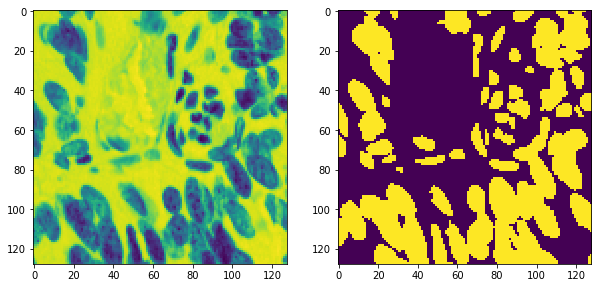

In [7]:
plot_check([np.squeeze(train_X,axis=3),np.squeeze(train_Y,axis=3)],rand_imgs=1,size=(10,7))


# Now Let's Build the Model

In [ ]:
# Loss and metric functions for the neural net
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

  
  ## used for meshnet
def create_block(x, filters=21, filter_size=(3, 3), activation='relu',dil_rate=1,dropout_rate=0.25,l2_reg=0):
    x = Conv2D(filters, filter_size, padding='same', activation=activation, dilation_rate = dil_rate,kernel_regularizer=regularizers.l2(l2_reg)) (x)
    #x = BatchNormalization() (x) 
    x = Dropout(dropout_rate) (x)
    return x

  
  
  ## used for dilated unet
  
def encoder(x, filters=44, n_block=3, kernel_size=(3, 3), activation='relu',dropout=0.2):
    skip = []
    for i in range(n_block):
        x = Conv2D(filters * 2**i, kernel_size, activation=activation, padding='same')(x)
        x = Dropout(dropout)(x)
        x = Conv2D(filters * 2**i, kernel_size, activation=activation, padding='same')(x)
        skip.append(x)
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    return x, skip


def bottleneck(x, filters_bottleneck, mode='cascade', depth=6, dropout=0.2,
               kernel_size=(3, 3), activation='relu'):
    dilated_layers = []
    if mode == 'cascade':  # used in the competition
        for i in range(depth):
            x = Conv2D(filters_bottleneck, kernel_size,
                       activation=activation, padding='same')(x)
            x = Dropout(dropout)(x)
            dilated_layers.append(x)
        return add(dilated_layers)
    elif mode == 'parallel':  # Like "Atrous Spatial Pyramid Pooling"
        for i in range(depth):
            dilated_layers.append(
                Conv2D(filters_bottleneck, kernel_size,
                       activation=activation, padding='same')(x)
            )
    return add(dilated_layers)


def decoder(x, skip, filters, n_block=3, kernel_size=(3, 3), activation='relu',dropout=0.2):
  for i in reversed(range(n_block)):
        x = UpSampling2D(size=(2, 2))(x)
        x = Conv2D(filters * 2**i, kernel_size, activation=activation, padding='same')(x)
        x = concatenate([skip[i], x])
        x = Conv2D(filters * 2**i, kernel_size, activation=activation, padding='same')(x)
        x = Dropout(dropout)(x)
        x = Conv2D(filters * 2**i, kernel_size, activation=activation, padding='same')(x)
  return x
  
## 3rd place carvana function
def get_dilated_unet(
        input_shape=(img_width, img_height, img_channels),
        mode='cascade',
        filters=44,
        n_block=3,
        lr=0.0001,
        loss=binary_crossentropy,
        n_class=1
):
    inputs = Input(input_shape)
    
    enc, skip = encoder(inputs, filters, n_block,dropout=0.25)
    bottle = bottleneck(enc, filters_bottleneck=filters * 2**n_block, mode=mode,depth=2,dropout=0.25)
    dec = decoder(bottle, skip, filters, n_block,dropout=0.25)
    classify = Conv2D(n_class, (1, 1), activation='sigmoid')(dec)

    model = Model(inputs=inputs, outputs=classify)
    model.compile(optimizer=Adam(lr), loss=loss, metrics=[dice_coef, bce_dice_loss])

    return model  
  
  
  ### non-dilated unet
def Unet(img_size):
    inputs = Input((img_size, img_size, img_channels))
    #s = Lambda(lambda x: x / 255)(inputs)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

  

## master function for creating a net
def get_net(
        input_shape=(img_height, img_width,img_channels),
        loss=binary_crossentropy,
        lr=0.001,
        n_class=1,
        nb_filters=21,
        dropout=0.2
):
    
    inputs = Input(input_shape)
    
    # Create layers
    net_body = create_block(inputs,filters=nb_filters,dropout_rate=dropout)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout,dil_rate=2)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout,dil_rate=4)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout,dil_rate=8)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout)
    classify = Conv2D(n_class,(1,1),activation='sigmoid') (net_body)

    model = Model(inputs=inputs, outputs=classify)
    
    model.compile(optimizer=Adam(lr), loss=loss, metrics=[bce_dice_loss, dice_coef])

    return model

#### CREATE MODEL ##########################################################

#my_model = get_net(nb_filters=21,dropout=0.1,loss=binary_crossentropy)
#my_model = Unet(img_height)
#my_model.compile(optimizer='adam', loss=binary_crossentropy, metrics=[bce_dice_loss, dice_coef])

my_model = get_dilated_unet(filters=16)

############################################################################

print(my_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        dropout_1[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [ ]:
# Fit model

earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint(model_checkpoint_file, verbose=1, save_best_only=True)
reduce_plateau = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.2,
                           patience=4,
                           verbose=1,
                        #   min_lr=0.00001,
                            epsilon=0.001,
                           mode='auto') 

results = my_model.fit(train_X, train_Y, validation_split=0.1, batch_size=1, epochs=100, verbose=1, 
                       shuffle=True, callbacks=[ earlystopper, checkpointer, reduce_plateau])

Train on 603 samples, validate on 67 samples
Epoch 1/100
603/603 [==============================] - 309s 512ms/step - loss: 0.3004 - dice_coef: 0.2749 - bce_dice_loss: 1.0031 - val_loss: 0.2283 - val_dice_coef: 0.5963 - val_bce_dice_loss: 0.7652

Epoch 00001: val_loss improved from inf to 0.22835, saving model to unet_v4.h5
Epoch 2/100
110/603 [====>.........................] - ETA: 4:47 - loss: 0.1891 - dice_coef: 0.6967 - bce_dice_loss: 0.6517

In [0]:
for val_loss in results.history['val_loss']:
    print(round(val_loss,3))
#print(results.history)

NameError: name 'results' is not defined

In [0]:
## Import Test Data and Make Predictions with Model

# Import images (either test or training)
# Decolorize, resize, store in array, and save filenames, etc.
test_X, test_images, test_filenames, test_dirs = import_images(test_root)


# Load model and make predictions on test data
final_model = load_model(model_checkpoint_file, custom_objects={'dice_coef': dice_coef, 'bce_dice_loss':bce_dice_loss})
preds_test = final_model.predict(test_X, verbose=1)

preds_test_t = (preds_test > 0.5) 

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (test_images[i].shape[0], test_images[i].shape[1]), 
                                       mode='constant', preserve_range=True))

preds_test_upsampled_bool = [ (mask > 0.5).astype(bool) for mask in preds_test_upsampled ]


FileNotFoundError: ignored

Image #: 39


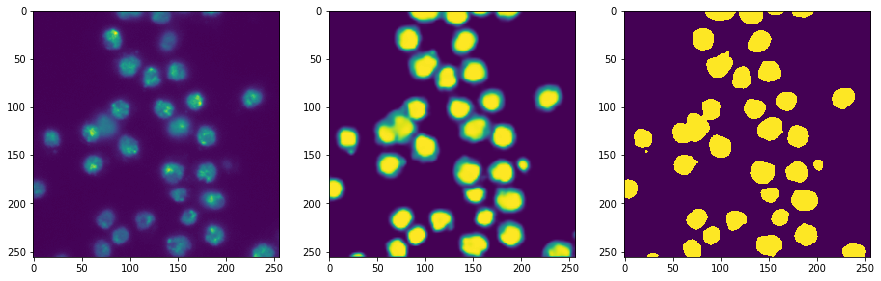

Image #: 58


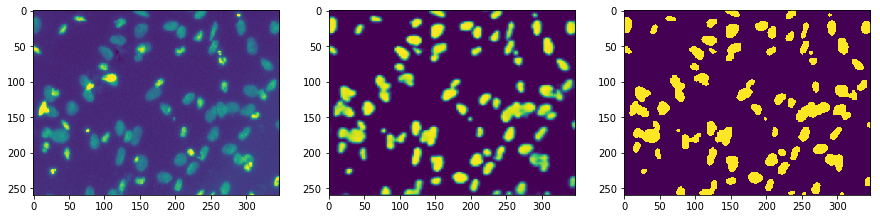

In [0]:
plot_check([test_images,preds_test_upsampled,preds_test_upsampled_bool],rand_imgs=2)

In [0]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

        
def generate_prediction_file(image_names,predictions,filename):
    new_test_ids = []
    rles = []
    for n, id_ in enumerate(image_names):
        rle = list(prob_to_rles(predictions[n]))
        rles.extend(rle)
        new_test_ids.extend([id_] * len(rle))
    sub = pd.DataFrame()
    sub['ImageId'] = new_test_ids
    sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
    sub.to_csv(filename, index=False)

In [0]:
generate_prediction_file(test_dirs,preds_test_upsampled_bool,submission_filename)

Ideas
 - Experiment with compression of training data. Am I preserving as much detail
    as I can in dtype np.uint8 (values of 0 to 255) ?
- Color vs B&W?
- Combine mask and prediction images to show false positives and negatives
- What is the best resizing method? Reflect??
- Put computer vision / threshold method output as an input to neural net
- Output intermediate layers for inspection
- Crop images to train networks faster for testing ??
- Take random crops of images to create, and then combine outputs in the end
- Is combining the masks really the best thing to do? Should I be keeping the individual cells separate?
- Pseudo-labelled data